# CS 109A Data Science: Project
**Harvard University**<br>
**Fall 2016**<br>
**Team member:** Becerra, Fernando; Mayo, Andrew Wayne; Ding, Yi; Cao, Xinrui<br>
**Project topic:** Predicting Seizures and Epilepsy

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import time
from scipy.stats import mode
from sklearn import linear_model
import sklearn.linear_model as sk
import matplotlib
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
import sklearn.discriminant_analysis as da
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import KFold
from sklearn.svm import LinearSVC
#import seaborn

%matplotlib inline

# 1 Data Cleaning

In [4]:
# Read in data set UKDA-2024-tab
UKDA16 = pd.read_table('./datasets/NCDS/ncds0123.tab')

/Users/Jessica/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,2,3,4,5,1756,1757,1758,1759,1760,1761,1762,1763,1764) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1.1 identify seizure individuals and relapse individuals

In [5]:
#sweep 1
# reason for special education
a = (UKDA16['n390'] =='10') | (UKDA16['n391'] =='10') | (UKDA16['n392'] =='10')
# Epileptic condition
b = (UKDA16['n415'] =='3') | (UKDA16['n415'] =='4')| (UKDA16['n415'] =='5') | (UKDA16['n415'] =='6')
# Fit or convulsion in 1st year of life
c = (UKDA16['n274'] == '2')
# Fit or convulsion after 1st year
d = (UKDA16['n275'] == '2')
# Epilepsy identification
e = (UKDA16['n1842']=='5')
s1 =a|b|c|d|e

In [6]:
# sweep 2
# Has child had epilepsy attacks
a = (UKDA16['n1307']=='1')|(UKDA16['n1307']=='2')|(UKDA16['n1307']=='3')|(UKDA16['n1307']=='4')|(UKDA16['n1307']=='5')
# Age at most recent epilepsy attack
UKDA16['n1314']
# Age at 1st epilepsy attack
UKDA16['n1317']
# Reason for special education
b = (UKDA16['n1477'] =='7') | (UKDA16['n1478'] =='7') | (UKDA16['n1479'] =='7')
# Reason for absence from school
c = (UKDA16['n1321']=='8') |(UKDA16['n1322']=='8')|(UKDA16['n1323']=='8')|(UKDA16['n1324']=='8')|(UKDA16['n1325']=='8') 
# Reason for prescription
d = (UKDA16['n1337']=='1') |(UKDA16['n1338']=='1')
# Ever seen specialist-convulsions,fits
e = (UKDA16['n1394']=='2')|(UKDA16['n1394']=='3')|(UKDA16['n1394']=='5')
# Has child ever had convulsions
f = (UKDA16['n1502'] =='2')| (UKDA16['n1502'] =='3')|(UKDA16['n1502'] =='4')
s2 = a|b|c|d|e
s1s2 =s1|s2

In [7]:
# sweep 3
# Type hcap for which will require help
a = (UKDA16['n2416'] =='7')
# Nature of child-s disability-
b = (UKDA16['n2663'] =='7')|(UKDA16['n2664'] =='7')|(UKDA16['n2665'] =='7')|(UKDA16['n2666'] =='7')|(UKDA16['n2667'] =='7')
# Category of child's handicap
c = (UKDA16['n1893'] =='8')|(UKDA16['n1894'] =='8')|(UKDA16['n1895'] =='8')
# Reason for hosp admiss last 12 mnths
d = (UKDA16['n1904'] =='17')
# Reason hosp outpatient last yr
e = (UKDA16['n1910'] =='17')
# Epilepsy
#f = (UKDA16['n2032'] =='17')
# Reason for absence from school
g = (UKDA16['n2554'] =='11')|(UKDA16['n2556'] =='11')|(UKDA16['n2557'] =='11')|(UKDA16['n2558'] =='11')|(UKDA16['n2559'] =='11')
# Hospital admissions
h = (UKDA16['n2598'] =='7') | (UKDA16['n2599'] =='7') | (UKDA16['n2600'] =='7') | (UKDA16['n2601'] =='7') 
# Hosp outpatient,diagnosed cond
j = (UKDA16['n2603'] =='10')|(UKDA16['n2604'] =='10')|(UKDA16['n2605'] =='10')|(UKDA16['n2606'] =='10')|(UKDA16['n2607'] =='10')|(UKDA16['n2608'] =='10')
# Convulsions,fits-unconsciousness
k = (UKDA16['n2614'] =='1')
# When convulsions,fits 1st occured
(UKDA16['n2615'] =='5')|(UKDA16['n2615'] =='5')
# Convulsions-most recent occurrence
l = (UKDA16['n2616'] =='1')|(UKDA16['n2616'] =='2')|(UKDA16['n2616'] =='3')|(UKDA16['n2616'] =='4')
s3 = d|e|g|h|j|l

In [8]:
# create response
y = np.zeros(len(UKDA16))
y = pd.DataFrame(y, index = UKDA16.index)
y[s1s2&s3] = 1
y = y[s1s2]
y = y.astype(int)
y = y[0] # This is required so that y has the right shape

In [9]:
print str(len(y))+' kids developed seizure before age 11, and '
print str(sum(y==1))+' of them relaped by age 16.'

1026 kids developed seizure before age 11, and 
250 of them relaped by age 16.


- From Sweep 1 and Sweep 2, we extract all children who had any sign of epilepsy and convulsion. 
- From Sweep 3, we extract all children who had any sign of epilepsy and convulsion after age 11 (eg. hospitalization for convulsion or epilepsy, recent occurence of convulsion within 7 years)
- We take the join of s1s2 and s3, which include all children who have sign of epilepsy before 11 and had recurrence after 11.

- Finally, we got 1026 kids who developed seizure before age 11 and 250 of them relapsed by age 16.

## 1.2 select predictors for model building

The high missingness in the data may interfere our analysis if they are not missing at random. Some irrelevant variables like date of survey may not help our model building, but the missingness will bias our model, so we conduct a process for preliminary screening.
- The dataset contains 1765 variables at first.
- Based on subject matter knowledge, we select social economic status and medical records relevant variates, 207 variables remains after this process.
- variables with missing rate > 0.5 were dropped, 188 variables remains.
- Impute missing data
- Access colinearity
## Add something here


### 1.2.1 Select based on subject matter knowledge

In [10]:
filename = "./datasets/NCDS/sweep1_new.txt"
s1_variable = []
for line in open(filename):
    if 'Pos.' in line:
        name = line.rstrip().replace("\t",' ').split(' ')[5]
        s1_variable.append(name)
        
print str(len(s1_variable)) + ' variables are selected from sweep 1'

126 variables are selected from sweep 1


In [11]:
filename = "./datasets/NCDS/sweep2_new.txt"
s2_variable = []
for line in open(filename):
    if 'Pos.' in line:
        name = line.rstrip().replace("\t",' ').split(' ')[5]
        s2_variable.append(name)
        
print str(len(s2_variable)) + ' variables are selected from sweep 2'

44 variables are selected from sweep 2


In [12]:
filename = "./datasets/NCDS/sweep3_new.txt"
s3_variable = []
for line in open(filename):
    if 'Pos.' in line:
        name = line.rstrip().replace("\t",' ').split(' ')[5]
        s3_variable.append(name)
        
print str(len(s3_variable)) + ' variables are selected from sweep 3'

37 variables are selected from sweep 3


In [13]:
variables = s1_variable + s2_variable + s3_variable
print str(len(variables))+' variables were selected in total'

207 variables were selected in total


### 1.2.2 Missing rate

For continuous variables, missing values are filled in as column mean.      
For categorical variables, missing values are tried in two ways:   
- 1) Fill in the most frequent category   
- 2) Fill in as 'missing category'    

It turns out that the accuracy for the second approach is better than the first on the whole, so we fill in the missing categorical data as 'missing category'

In [14]:
data = UKDA16[variables][s1s2]

In [15]:
a = (data=='-1').sum(axis =0)/1046
b = (data==' ').sum(axis =0)/1046
sum(a+b<0.5)

188

In [16]:
#drop data with >0.5 missing rate
data = data[list(data.columns[np.where(a+b<0.5)])]

# fill in the blanks as '-1'
for col in data.columns:
    value = data[col]
    missing_index = (value == ' ')
    data[col][missing_index] = '-1'

In [17]:
data = data.convert_objects(convert_numeric=True)
data.shape

/Users/Jessica/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


(1026, 188)

In [18]:
# fill in the missing data
for col in data.columns:
    value = data[col]
    if(len(np.unique(value))>20):
        missing_index = (value == -1)
        filled_index = (value != -1)
        data[col][missing_index] = np.mean(value[filled_index])

/Users/Jessica/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### 1.2.3 Access colinearity

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif_(X):
    thresh = 10.0
    variables = range(X.shape[1])

    for i in np.arange(0, len(variables)):
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]
        #print(vif)
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            #print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]

    print('Remaining variables:')
    print(X.columns[variables])
    return X

In [48]:
calculate_vif_(data)

Remaining variables:
Index([u'n622', u'n0region', u'n3region', u'n490', u'n492', u'n524', u'n526',
       u'n496', u'n500', u'n502', u'n503', u'n504', u'n548', u'n518', u'n519',
       u'n522', u'n527', u'n528', u'n529', u'n531', u'n534', u'n535', u'n556',
       u'n646', u'n516', u'n660', u'n505', u'n507', u'n509', u'n121', u'n658',
       u'n659', u'n183', u'n1811', u'n403', u'n434', u'n436', u'n438', u'n440',
       u'n442', u'n444', u'n446', u'n448', u'n450', u'n452', u'n454', u'n1287',
       u'n1396', u'n1397', u'n1447', u'n1448', u'n1449', u'n1452', u'n1453',
       u'n1454', u'n1458', u'n1171', u'n1176', u'n1212', u'n1523', u'n1001',
       u'n1005', u'n983', u'n992', u'n995', u'n989', u'n986', u'n1004',
       u'n998', u'n974', u'n980', u'n977', u'n2385', u'n2400', u'n2401',
       u'n2452', u'n2504', u'n2517', u'n2522', u'n2523', u'n2531', u'n2560',
       u'n2624', u'n2631', u'n2020', u'n2021', u'n2029', u'n2030'],
      dtype='object')


,n622,n0region,n1region,n2region,n3region,n545,n490,n492,n524,n526,...,n2531,n2534,n2560,n2624,n2631,n2020,n2021,n2029,n2030,n2034
7,1,10,-1,10,10,4,3,6,-1,-1,...,1,2,7,1,5,1,1,1,1,1
25,1,2,10,10,10,4,5,3,1,4,...,2,1,7,1,1,1,1,1,1,1
34,1,9,8,8,8,4,4,4,-1,10,...,1,1,11,1,1,1,1,1,2,1
56,2,5,8,-1,-1,4,5,3,10,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
61,2,7,7,7,7,4,2,5,3,6,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
64,1,7,7,7,7,4,5,3,7,4,...,1,1,11,1,1,1,1,1,1,1
91,2,2,2,2,2,4,5,3,1,4,...,-1,-1,-1,-1,-1,1,1,1,1,1
98,2,11,11,11,11,4,1,4,2,5,...,1,1,7,1,1,1,1,1,1,1
102,2,3,3,3,3,4,1,4,1,4,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
138,2,1,1,1,1,4,5,3,9,4,...,1,1,11,3,1,1,1,1,1,1


In [19]:
data_update = data[[u'n622', u'n0region', u'n3region', u'n490', u'n492', u'n524', u'n526',
       u'n496', u'n500', u'n502', u'n503', u'n504', u'n548', u'n518', u'n519',
       u'n522', u'n527', u'n528', u'n529', u'n531', u'n534', u'n535', u'n556',
       u'n646', u'n516', u'n660', u'n505', u'n507', u'n509', u'n121', u'n658',
       u'n659', u'n183', u'n1811', u'n403', u'n434', u'n436', u'n438', u'n440',
       u'n442', u'n444', u'n446', u'n448', u'n450', u'n452', u'n454', u'n1287',
       u'n1396', u'n1397', u'n1447', u'n1448', u'n1449', u'n1452', u'n1453',
       u'n1454', u'n1458', u'n1171', u'n1176', u'n1212', u'n1523', u'n1001',
       u'n1005', u'n983', u'n992', u'n995', u'n989', u'n986', u'n1004',
       u'n998', u'n974', u'n980', u'n977', u'n2385', u'n2400', u'n2401',
       u'n2452', u'n2504', u'n2517', u'n2522', u'n2523', u'n2531', u'n2560',
       u'n2624', u'n2631', u'n2020', u'n2021', u'n2029', u'n2030']]

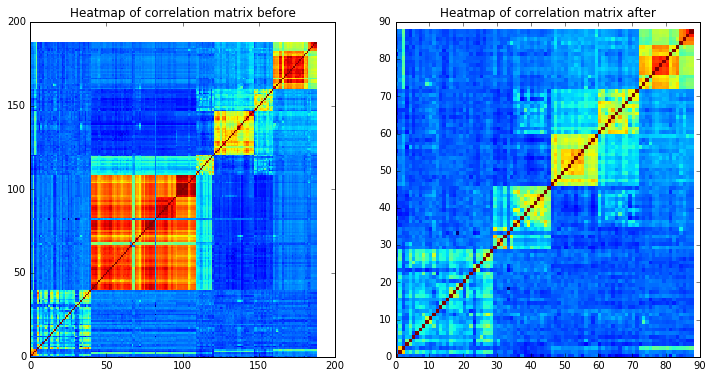

In [20]:
corr_matrix_before = np.corrcoef(data.T)
corr_matrix_after  = np.corrcoef(data_update.T)

# Display heat map 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].pcolor(corr_matrix_before)
ax[0].set_title('Heatmap of correlation matrix before')
ax[1].pcolor(corr_matrix_after)
ax[1].set_title('Heatmap of correlation matrix after')

plt.show()

In [21]:
data = data_update
data.shape

(1026, 88)

### 1.2.4 transform into dummy variable

In [22]:
data_dummy=pd.DataFrame()

for i in data.columns:
    if len(np.unique(data[i]))<=20:
        data_dummy=pd.concat([data_dummy, pd.get_dummies(data[i])], axis=1)
    else:
        data_dummy=pd.concat([data_dummy, data[i]], axis=1)

data_dummy.shape

(1026, 768)

# 2 Model building

Predictors are in `data_dummy`, response is in `y`.   
Given that the dataset is inbalanced, we adopt two strategies: 1) weighted model; 2) balanced sample  


In [23]:
#Function for computing the accuracy a given model on the entire test set, the accuracy on class 0 in the test set
#and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])

# 2.1 weighted model

### 2.1.1 Cross-validation to select best hyperparameter

In [24]:
def cross_validation_weighted(x, y, param, method):
    y_cv = y
    x_cv = x
    y_cv.index = range(len(y))
    x_cv.index = range(len(y))
    
    n_param = len(param)
    score_train = np.zeros([n_param,5])
    score_test = np.zeros([n_param,5])
    accuracy_0 = np.zeros([n_param,5])
    accuracy_1 = np.zeros([n_param,5])
    score_K = np.zeros([n_param,4])
    kf = KFold(len(y_cv),5, shuffle=True)
    
    j=0 #index the jth fold

    for train_idx, test_idx in kf:

        # get training and testing sets 
        y_train, x_train = y_cv.ix[train_idx, ], x_cv.ix[train_idx, ]
        y_test , x_test  = y_cv.ix[test_idx, ], x_cv.ix[test_idx, ]

        # fit Lasso regression with varying lambda
        for i in range(n_param):
            if method == 'logreg':
                model = LogisticRegression(C=10**param[i], class_weight='balanced', penalty='l1')
            elif method == 'dt':
                model = DecisionTree(max_depth=param[i], class_weight = "balanced")
            elif method == 'rf':
                model = RandomForest(max_depth=param[i], class_weight = 'balanced')
            elif method =='linearsvc':
                model = LinearSVC(C=10**param[i], penalty="l1", dual=False, class_weight = 'balanced')
          
            model.fit(x_train, y_train)
            score_train[i,j] = model.score(x_train, y_train)
            score_test[i,j] = model.score(x_test, y_test)
            accuracy_0[i,j] = model.score(x_test[y_test==0], y_test[y_test==0])
            accuracy_1[i,j] = model.score(x_test[y_test==1], y_test[y_test==1])

        # calculate r-squared mean across five fold for each lamda
        for i in range(n_param):
            score_K[i,0]=score_train[i,:].mean()
            score_K[i,1]=score_test[i,:].mean()
            score_K[i,2]=accuracy_0[i,:].mean()
            score_K[i,3]=accuracy_1[i,:].mean()

        j=j+1  
        
    plt.figure(figsize=(8,6))
    plt.plot(param,score_K[:,0],'ro-', label ='train set')          
    plt.plot(param,score_K[:,1],'bo-', label ='test set') 
    plt.plot(param,score_K[:,2],'rs-', label ='test set: Non-relapse') 
    plt.plot(param,score_K[:,3],'bs-', label ='test set: relapse')  
    plt.legend(loc = 'best')         

    plt.show()

In [25]:
x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, test_size=0.6)

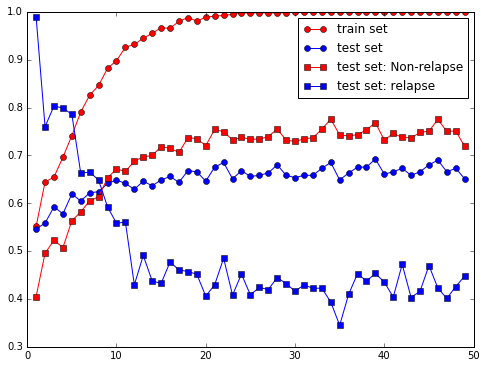

In [26]:
cross_validation_weighted(x_train, y_train, range(1,50), 'dt')

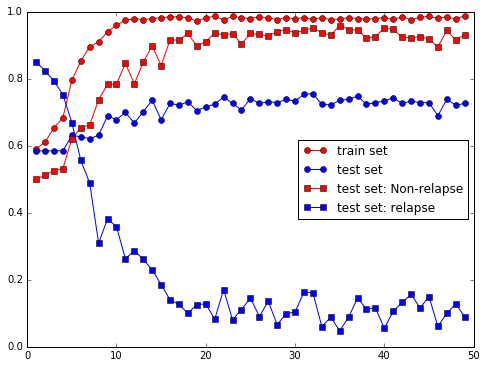

In [27]:
cross_validation_weighted(x_train, y_train, range(1,50), 'rf')

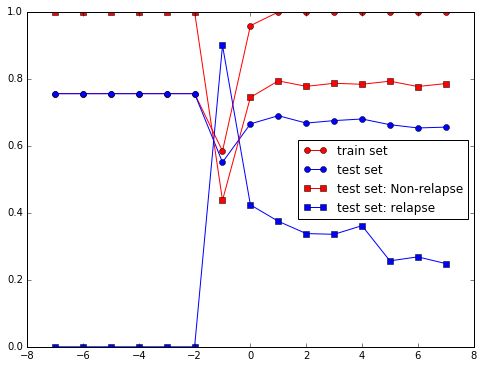

In [28]:
cross_validation_weighted(x_train, y_train, range(-7,8), 'logreg')

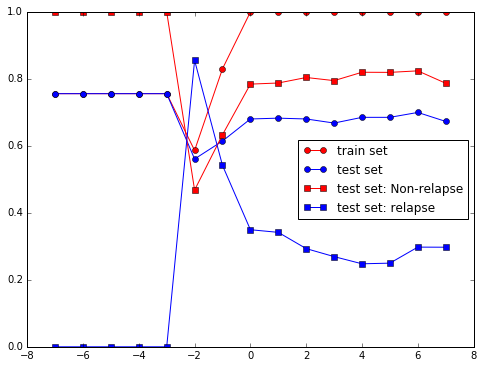

In [32]:
cross_validation_weighted(x_train, y_train, range(-7,8), 'linearsvc')

### 2.1.2 Compare different models

In [33]:
weighted={}
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, test_size=0.6)
    #Weighted logistic regression
    weighted_logistic = LogisticRegression(class_weight='balanced', penalty = 'l1', C = 0.1)
    weighted_logistic.fit(x_train, y_train)
    weighted_log_scores = score(weighted_logistic, x_test, y_test)

    #LDA
    weighted_lda = LDA(priors = [0.5,0.5])
    weighted_lda.fit(x_train, y_train)
    weighted_lda_scores = score(weighted_lda, x_test, y_test)


    #QDA
    weighted_qda = QDA(priors = [0.5,0.5])
    weighted_qda.fit(x_train, y_train)
    weighted_qda_scores = score(weighted_qda, x_test, y_test)


    #Decision Tree
    weighted_tree = DecisionTree(class_weight = "balanced")
    weighted_tree.fit(x_train, y_train)
    weighted_tree_scores = score(weighted_tree, x_test, y_test)


    #Random Forest
    weighted_rf = RandomForest(class_weight = 'balanced')
    weighted_rf.fit(x_train, y_train)
    weighted_rf_scores = score(weighted_rf, x_test, y_test)



    # linearsvm
    weighted_linearsvm= LinearSVC(class_weight = 'balanced', C=0.01, penalty="l1", dual=False)
    weighted_linearsvm.fit(x_train, y_train)
    weighted_linearsvm_scores = score(weighted_linearsvm, x_test, y_test)


    weighted_score_df = pd.DataFrame({'weighted logistic': weighted_log_scores,
                             'weighted lda': weighted_lda_scores,
                             'weighted qda': weighted_qda_scores,
                             'weighted tree': weighted_tree_scores,
                             'weighted rf': weighted_rf_scores,
                            'weighted linear svm': weighted_linearsvm_scores})
    weighted[i] = weighted_score_df

/Users/Jessica/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/Jessica/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:688: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [34]:
weighted_1 = np.zeros((100,6))
names = ['weighted logistic', 'weighted lda', 'weighted qda', 'weighted tree', 
         'weighted rf', 'weighted linear svm']
weighted_1 = pd.DataFrame(weighted_1, columns = names)
for i in range(100):
    for j in names:
        weighted_1[j][i]=weighted[i][j][2]
        
weighted_0 = np.zeros((100,6))
names = ['weighted logistic', 'weighted lda', 'weighted qda', 'weighted tree', 
         'weighted rf', 'weighted linear svm']
weighted_0 = pd.DataFrame(weighted_0, columns = names)
for i in range(100):
    for j in names:
        weighted_0[j][i]=weighted[i][j][1]
        
weighted_all = np.zeros((100,6))
names = ['weighted logistic', 'weighted lda', 'weighted qda', 'weighted tree', 
         'weighted rf', 'weighted linear svm']
weighted_all = pd.DataFrame(weighted_all, columns = names)
for i in range(100):
    for j in names:
        weighted_all[j][i]=weighted[i][j][0]


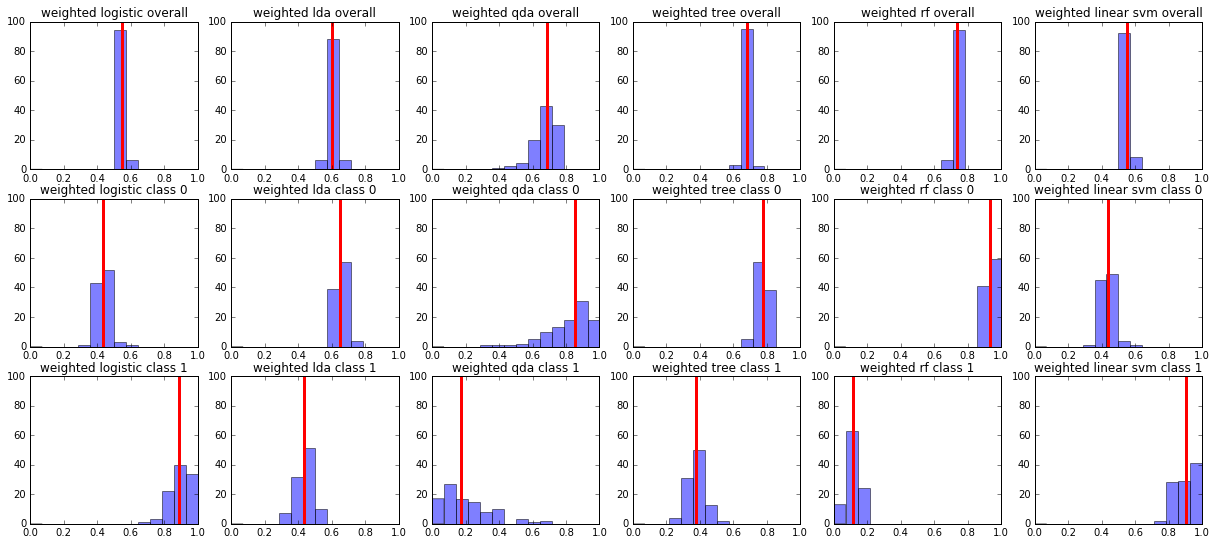

In [35]:
# plot accuracy for each model
fig, ax = plt.subplots(3, 6, figsize=(21, 9))  
for i in range(6): 
    model = names[i]
    
    ax[0][i].hist(weighted_all[model], bins = np.linspace(0, 1, 15), alpha = 0.5)
    ax[0][i].axvline(x = np.median(weighted_all[model]) , linewidth=3, color = 'red')
    ax[0][i].set_title(model+' overall')
    ax[0][i].set_ylim(0,100)
    
    ax[1][i].hist(weighted_0[model], bins = np.linspace(0, 1, 15), alpha = 0.5)
    ax[1][i].axvline(x = np.median(weighted_0[model]) , linewidth=3, color = 'red')
    ax[1][i].set_title(model+' class 0')
    ax[1][i].set_ylim(0,100)
    
    ax[2][i].hist(weighted_1[model], bins = np.linspace(0, 1, 15), alpha = 0.5)
    ax[2][i].axvline(x = np.median(weighted_1[model]) , linewidth=3, color = 'red')
    ax[2][i].set_title(model+' class 1')
    ax[2][i].set_ylim(0,100) 

## 2.2 Balanced Sample

### 2.1.1 Cross-validation to select best hyperparameter

In [36]:
def cross_validation_balanced(x, y, param, method):
    y_cv = y
    x_cv = x
    y_cv.index = range(len(y))
    x_cv.index = range(len(y))
    
    n_param = len(param)
    score_train = np.zeros([n_param,5])
    score_test = np.zeros([n_param,5])
    accuracy_0 = np.zeros([n_param,5])
    accuracy_1 = np.zeros([n_param,5])
    score_K = np.zeros([n_param,4])
    kf = KFold(len(y_cv),5, shuffle=True)
    
    j=0 #index the jth fold

    for train_idx, test_idx in kf:
        

        # get training and testing sets 
        y_train, x_train = y_cv.ix[train_idx, ], x_cv.ix[train_idx, ]
        y_test , x_test  = y_cv.ix[test_idx, ], x_cv.ix[test_idx, ]
        ind0 = np.random.choice(y_train[y_train==0].index, 300, replace=True)
        ind1 = np.random.choice(y_train[y_train==1].index, 300, replace=True)
        x_frames = [x_train.ix[ind0,], x_train.ix[ind1, ]]
        x_train_sub = pd.concat(x_frames, axis = 0)
        y_frames = [y_train[ind0], y_train[ind1]]
        y_train_sub = pd.concat(y_frames, axis = 0)

        # fit Lasso regression with varying lambda
        for i in range(n_param):
            if method == 'logreg':
                model = LogisticRegression(C=10**param[i], penalty='l1')
            elif method == 'dt':
                model = DecisionTree(max_depth=param[i])
            elif method == 'rf':
                model = RandomForest(max_depth=param[i])
            elif method =='linearsvc':
                model = LinearSVC(C=10**param[i], penalty="l1", dual=False)
          
            model.fit(x_train_sub, y_train_sub)
            score_train[i,j] = model.score(x_train_sub, y_train_sub)
            score_test[i,j] = model.score(x_test, y_test)
            accuracy_0[i,j] = model.score(x_test[y_test==0], y_test[y_test==0])
            accuracy_1[i,j] = model.score(x_test[y_test==1], y_test[y_test==1])

        # calculate r-squared mean across five fold for each lamda
        for i in range(n_param):
            score_K[i,0]=score_train[i,:].mean()
            score_K[i,1]=score_test[i,:].mean()
            score_K[i,2]=accuracy_0[i,:].mean()
            score_K[i,3]=accuracy_1[i,:].mean()

        j=j+1  
        
    plt.figure(figsize=(8,6))
    plt.plot(param,score_K[:,0],'ro-', label ='train set')          
    plt.plot(param,score_K[:,1],'bo-', label ='test set') 
    plt.plot(param,score_K[:,2],'rs-', label ='test set: Non-relapse') 
    plt.plot(param,score_K[:,3],'bs-', label ='test set: relapse')  
    plt.legend(loc = 'best')         

    plt.show()

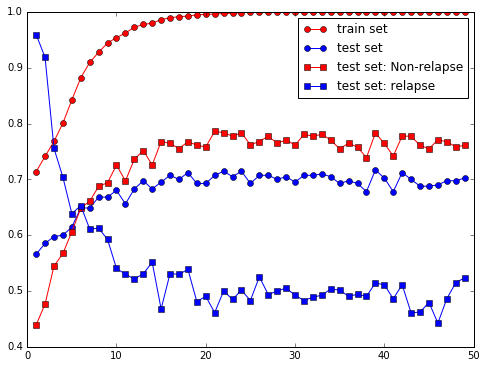

In [37]:
cross_validation_balanced(x_train, y_train, range(1,50), 'dt')

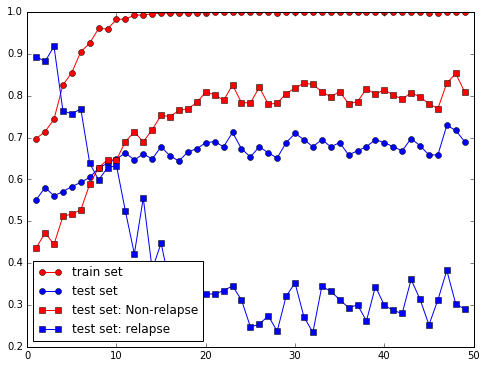

In [38]:
cross_validation_balanced(x_train, y_train, range(1,50), 'rf')

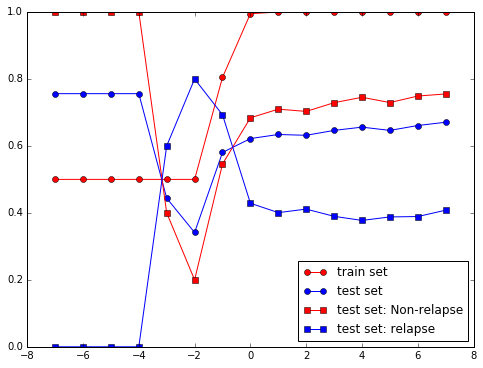

In [39]:
cross_validation_balanced(x_train, y_train, range(-7,8), 'logreg')

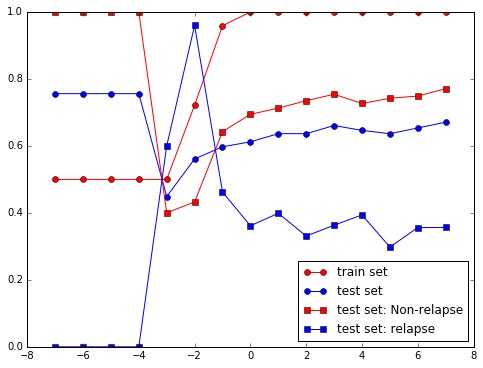

In [40]:
cross_validation_balanced(x_train, y_train, range(-7,8), 'linearsvc')

### 2.2.2 Compare different models

In [181]:
balanced={}
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, test_size=0.6)
    
    n=500
    ind0 = np.random.choice(y_train[y_train==0].index, n, replace=True)
    ind1 = np.random.choice(y_train[y_train==1].index, n, replace=True)
    x_frames = [x_train.ix[ind0,], x_train.ix[ind1, ]]
    x_train_sub = pd.concat(x_frames, axis = 0)
    y_frames = [y_train[ind0], y_train[ind1]]
    y_train_sub = pd.concat(y_frames, axis = 0)
    
    #balanced logistic regression
    balanced_logistic = LogisticRegression(penalty = 'l1', C = 0.1)
    balanced_logistic.fit(x_train_sub, y_train_sub)
    balanced_log_scores = score(balanced_logistic, x_test, y_test)

    #LDA
    balanced_lda = LDA()
    balanced_lda.fit(x_train_sub, y_train_sub)
    balanced_lda_scores = score(balanced_lda, x_test, y_test)


    #QDA
    balanced_qda = QDA()
    balanced_qda.fit(x_train_sub, y_train_sub)
    balanced_qda_scores = score(balanced_qda, x_test, y_test)


    #Decision Tree
    balanced_tree = DecisionTree()
    balanced_tree.fit(x_train_sub, y_train_sub)
    balanced_tree_scores = score(balanced_tree, x_test, y_test)


    #Random Forest
    balanced_rf = RandomForest()
    balanced_rf.fit(x_train_sub, y_train_sub)
    balanced_rf_scores = score(balanced_rf, x_test, y_test)



    # linearsvm
    balanced_linearsvm= LinearSVC(C=0.01, penalty="l1", dual=False)
    balanced_linearsvm.fit(x_train_sub, y_train_sub)
    balanced_linearsvm_scores = score(balanced_linearsvm, x_test, y_test)


    balanced_score_df = pd.DataFrame({'balanced logistic': balanced_log_scores,
                             'balanced lda': balanced_lda_scores,
                             'balanced qda': balanced_qda_scores,
                             'balanced tree': balanced_tree_scores,
                             'balanced rf': balanced_rf_scores,
                            'balanced linear svm': balanced_linearsvm_scores})
    balanced[i] = balanced_score_df
    if i%10==0: print(i)

0
10
20
30
40
50
60
70
80
90


In [42]:
balanced_1 = np.zeros((100,6))
names = ['balanced logistic', 'balanced lda', 'balanced qda', 'balanced tree', 
         'balanced rf', 'balanced linear svm']
balanced_1 = pd.DataFrame(balanced_1, columns = names)
for i in range(100):
    for j in names:
        balanced_1[j][i]=balanced[i][j][2]
        
balanced_0 = np.zeros((100,6))
names = ['balanced logistic', 'balanced lda', 'balanced qda', 'balanced tree', 
         'balanced rf', 'balanced linear svm']
balanced_0 = pd.DataFrame(balanced_0, columns = names)
for i in range(100):
    for j in names:
        balanced_0[j][i]=balanced[i][j][1]
        
balanced_all = np.zeros((100,6))
names = ['balanced logistic', 'balanced lda', 'balanced qda', 'balanced tree', 
         'balanced rf', 'balanced linear svm']
balanced_all = pd.DataFrame(balanced_all, columns = names)
for i in range(100):
    for j in names:
        balanced_all[j][i]=balanced[i][j][0]

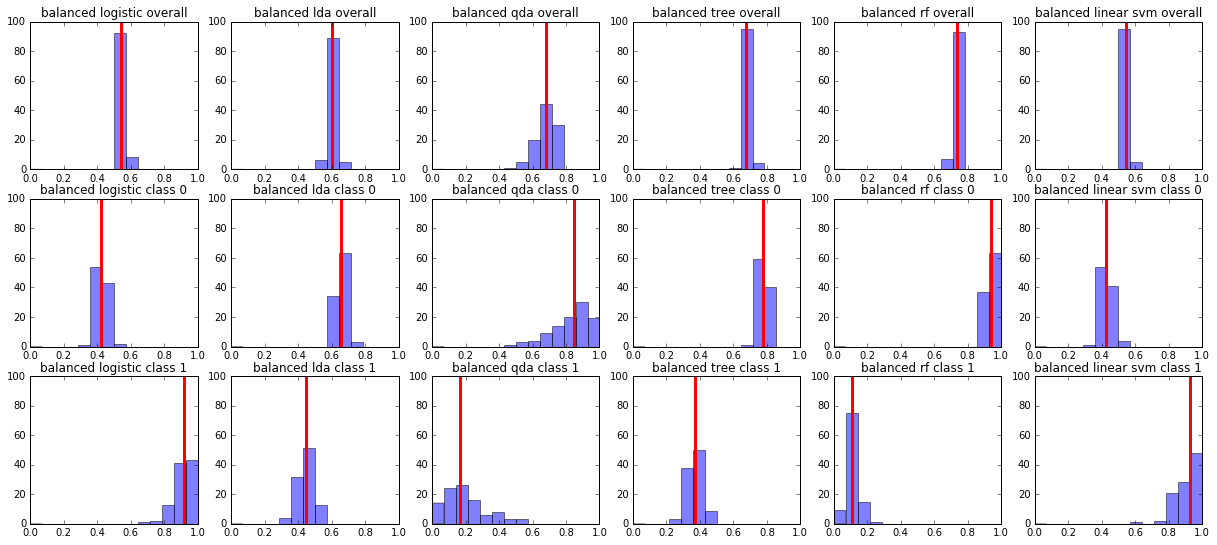

In [43]:
# plot accuracy for each model
fig, ax = plt.subplots(3, 6, figsize=(21, 9))  
for i in range(6): 
    model = names[i]
    
    ax[0][i].hist(balanced_all[model], bins = np.linspace(0, 1, 15), alpha = 0.5)
    ax[0][i].axvline(x = np.median(balanced_all[model]) , linewidth=3, color = 'red')
    ax[0][i].set_title(model+' overall')
    ax[0][i].set_ylim(0,100)
    
    ax[1][i].hist(balanced_0[model], bins = np.linspace(0, 1, 15), alpha = 0.5)
    ax[1][i].axvline(x = np.median(balanced_0[model]) , linewidth=3, color = 'red')
    ax[1][i].set_title(model+' class 0')
    ax[1][i].set_ylim(0,100)
    
    ax[2][i].hist(balanced_1[model], bins = np.linspace(0, 1, 15), alpha = 0.5)
    ax[2][i].axvline(x = np.median(balanced_1[model]) , linewidth=3, color = 'red')
    ax[2][i].set_title(model+' class 1')
    ax[2][i].set_ylim(0,100) 

## 2.3 Model Comparison

# 3 Final Model

In [44]:
x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, test_size=0.6)

In [45]:
weighted_linearsvm= LinearSVC(class_weight = 'balanced', C=0.01, penalty="l1", dual=False)
weighted_linearsvm.fit(x_train, y_train)
weighted_linearsvm_scores = score(weighted_linearsvm, x_test, y_test)
weighted_linearsvm_scores

overall accuracy       0.534091
accuracy on class 0    0.389610
accuracy on class 1    0.967532
dtype: float64

In [46]:
weighted_logistic = LogisticRegression(class_weight='balanced', penalty = 'l1', C = 0.1)
weighted_logistic.fit(x_train, y_train)
weighted_log_scores = score(weighted_logistic, x_test, y_test)
weighted_log_scores

overall accuracy       0.535714
accuracy on class 0    0.391775
accuracy on class 1    0.967532
dtype: float64

# 4 Plot

In [47]:
# A function to find feature name
def find_feature(position, index, features):
    n = len(features)
    for i in range(n-1):
        if position in range(index[i],index[i+1]):
            break
    return features[i]
    

In [48]:
index = [0]
i = 0
for col in data.columns:
    x = np.unique(data[col])
    if len(x)<=20:
        i = i+len(x)
    else:
        i = i+1
    index = index + [i]
    
features = list(data.columns)

find_feature(3, index, features)

'n0region'

Non-relapse and relapse accuracies are based on the *whole* dataset -- It is basically a misclassification rate. To calculate the prediction we use a majority vote based on `n_iter = 10`, just like we did in previous homework. For the case of decision tree and random forest, we also calculate the optimal depth.

## optimize decision tree method

In [146]:
x_train, x_test, y_train, y_test = train_test_split(data_dummy, y, train_size=0.7)

n=500
ind0 = np.random.choice(y_train[y_train==0].index, n, replace=True)
ind1 = np.random.choice(y_train[y_train==1].index, n, replace=True)
x_frames = [x_train.ix[ind0,], x_train.ix[ind1, ]]
x_train_sub = pd.concat(x_frames, axis = 0)
y_frames = [y_train[ind0], y_train[ind1]]
y_train_sub = pd.concat(y_frames, axis = 0)

In [147]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

pred_matrix = np.zeros((len(y_test),100))
importance_matrix = np.zeros((768, 100))
for i in range(100):
    weighted_logistic.fit(x_train, y_train)
    model = SelectFromModel(weighted_logistic, prefit=True)
    #x_train_sub_new = model.transform(x_train_sub)
    #print x_train_sub_new.shape
    
    pred_matrix[:,i] = weighted_logistic.predict(x_test)
    importance_matrix[:,i] = abs(weighted_logistic.coef_)
    #print importance_matrix[:, i]

In [148]:
# pred_matrix = np.zeros((len(y_test),100))
# importance_matrix = np.zeros((768, 100))
# for i in range(100):
#     weighted_tree.fit(x_train_sub, y_train_sub)
#     pred_matrix[:,i] = weighted_tree.predict(x_test)
#     importance_matrix[:,i] = weighted_tree.feature_importances_
#     #importance_matrix[:,i] = dt.transform(x_test)
#     print importance_matrix[:, i]

In [149]:
results = pred_matrix.mean(axis =1)
results[results > 0.5 ]=1
results[results < 0.5 ]=0
results[results ==0.5] = np.random.choice([0,1])
print('accuracy of non-relapse:')
print np.mean((results == y_test)[y_test ==0])
print('accuracy of relapse:')
print np.mean((results == y_test)[y_test ==1])

accuracy of non-relapse:
0.437768240343
accuracy of relapse:
0.92


## get important features

In [150]:
importance = importance_matrix.mean(axis =1)
indices = np.argsort(importance)[::-1][0:20]

namelist = []
for ind in indices:
    name = find_feature(ind, index, features)
    namelist.append(name)
print namelist
print importance[indices]

['n2531', 'n2631', 'n2522', 'n2624', 'n2522', 'n450', 'n504', 'n2631', 'n183', 'n2452', 'n522', 'n509', 'n1004', 'n1454', 'n2504', 'n519', 'n526', 'n1212', 'n2560', 'n646']
[  1.43509062e+00   4.36880277e-01   3.79764857e-01   2.63331684e-01
   2.14603640e-01   1.96258201e-01   1.38974277e-01   1.11488386e-01
   7.55569295e-02   6.96739666e-02   6.51936268e-02   3.65268801e-02
   3.17228708e-02   3.06427369e-02   3.00051271e-02   2.99178217e-02
   2.63020692e-02   4.91999257e-03   4.63253087e-03   1.13910180e-03]


In [151]:
# import plotly.plotly as py
# import plotly.graph_objs as go

# # non-relapse accuracy
# trace0 = go.Bar(
#     x=['LogReg', 'LDA', 'QDA', 'DT', 'RF', 'SVC linear','SVC quadratic'],
#     y=[float(logreg_cm[0, 0]) / logreg_cm[0].sum(), float(lda_cm[0, 0]) / lda_cm[0].sum(),
#       float(qda_cm[0, 0]) / qda_cm[0].sum(), float(dt_cm[0, 0]) / dt_cm[0].sum(),
#       float(rf_cm[0, 0]) / rf_cm[0].sum(), float(svc_linear_cm[0, 0]) / svc_linear_cm[0].sum(),
#       float(svc_quad_cm[0, 0]) / svc_quad_cm[0].sum()],
#     name='Non-replase Accuracies',
#     marker=dict(
#         color='rgb(49,130,189)'
#     )
# )
# # replase accuracy
# trace1 = go.Bar(
#     x=['LogReg', 'LDA', 'QDA', 'DT', 'RF', 'SVC linear','SVC quadratic'],
#     y=[float(logreg_cm[1, 1]) / logreg_cm[1].sum(), float(lda_cm[1, 1]) / lda_cm[1].sum(),
#       float(qda_cm[1, 1]) / qda_cm[1].sum(), float(dt_cm[1, 1]) / dt_cm[1].sum(),
#       float(rf_cm[1, 1]) / rf_cm[1].sum(), float(svc_linear_cm[1, 1]) / svc_linear_cm[1].sum(),
#       float(svc_quad_cm[1, 1]) / svc_quad_cm[1].sum()],
#     name='Replase Accuracies',
#     marker=dict(
#         color='rgb(204,204,204)',
#     )
# )

# data1 = [trace0, trace1]
# layout = go.Layout(
#     xaxis=dict(tickangle=-45),
#     barmode='group',
# )

# fig = go.Figure(data=data1, layout=layout)
# py.iplot(fig, filename='angled-text-bar')

Feature ranking:
1. feature 710 (1.435091)
2. feature 734 (0.436880)
3. feature 702 (0.379765)
4. feature 726 (0.263332)
5. feature 704 (0.214604)
6. feature 410 (0.196258)
7. feature 118 (0.138974)
8. feature 733 (0.111488)
9. feature 312 (0.075557)
10. feature 683 (0.069674)
11. feature 163 (0.065194)
12. feature 280 (0.036527)
13. feature 601 (0.031723)
14. feature 485 (0.030643)
15. feature 695 (0.030005)
16. feature 161 (0.029918)
17. feature 68 (0.026302)
18. feature 511 (0.004920)
19. feature 715 (0.004633)
20. feature 248 (0.001139)


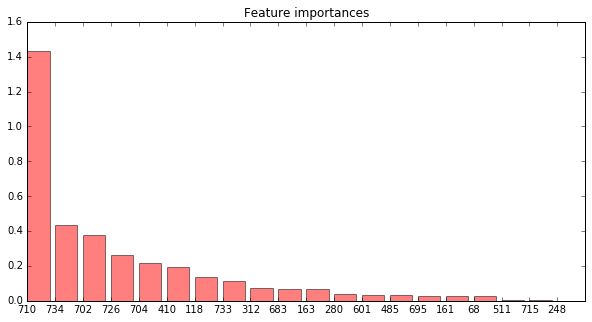

In [152]:
# Compute the feature importances for decision tree
# Print the feature ranking
print("Feature ranking:")

#for f in range(x_train.shape[1]):
for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (10,5))
plt.title("Feature importances")

#Bar plot of the frequencies of the top words
plt.bar(range(20), importance[indices], color='red', alpha=0.5)

#Label the bars with the top words
plt.xticks(range(20), indices)
plt.show()

In [ ]:
import plotly
plotly.tools.set_credentials_file(username='xinruicao', api_key='GBPqjuPjh3Gwc6Q3L9Te')

In [177]:
import plotly.plotly as py
import plotly.graph_objs as go

#  'n2531', 3P Fearful of new situations or things
#  'n2631', 3P Seen specialist-emotional prob-MC 1:4
#  'n2522', 3P Often worries about things
#  'n2624', 3P Any migraine,headaches in past year
#  'n2522', 3P Often worries about things
#  'n450', 1S BSAG- Inconsequential behaviour
#  'n504', Parity
#  'n2631', 3P Seen specialist-emotional prob-MC 1:4
#  'n183', Illness noted in PMS-MC 1:3
#  'n2452', 3P Source of income past year-MC 1:10
#  'n522', Abnormality during pregnancy
#  'n509', Past complications of pregnancy, etc
#  'n1004', 2S Tot score-BSAG Miscellaneous Symptoms
#  'n1454', 2P Is child irritable,quick tempered
#  'n2504', 3P Temper tantrums in past 12m
#  'n519', Mums min. haemoglobin while pregnant
#  'n526', Mothers fathers social class (GRO 1951)
#  'n1212', 2P Has mum had paid work since 1965
#  'n2560', 3P Illnesses in past 12 mths-MC 1:6
#  'n646', Birthweight (ounces) or estimate

y_short = ['Fearful of new','emotional prob1', 'Often worried1',
    'headache past yr', 'Often worried2', 'Inconsequential behave',
    'Parity', 'emotional prob2', 'Illness',
    'Source income', 'Abnormal pregnancy', 'complication pregnancy', 'Miscellaneous symptom',
    'Irritable', 'Temper past yr',  
    'Min haemoglobin pregnancy', 'Parents social class', 'Mom work',
    'Illnesses past yr', 'Birthweight']

trace0 = go.Bar(
    y= y_short,
    x= list(importance[indices]),
    text=list(namelist),
    marker=dict(
        color='rgb(400,202,225)',
        line=dict(
            color='rgb(8,48,107)',
            width=1.0,
        )
    ),
    orientation = 'h',
    hoverinfo ='x+y',
    opacity=0.8
)

data1 = [trace0]
layout = go.Layout(
    title='Feature importances',
    yaxis=dict(
        showgrid=True,
        gridcolor='#bdbdbd',
        gridwidth=2,     
        showticklabels=True,
        tickangle=45,
        tickfont=dict(
            family='Old Standard TT, serif',
            size=10,
            color='black'
        )
    )
)

fig = go.Figure(data=data1, layout=layout)
py.iplot(fig, filename='bar plot')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~xinruicao/0 or inside your plot.ly account where it is named 'bar plot'


In [156]:
# # Pie chart on varialbe 'n2030'
# haematological = list(data['n2030'])
# print len(haematological)
# print len(y)

# d = {'Haematological': haematological, 'y': y}
# demo_haematological = pd.DataFrame(data=d)
# demo_haematological.head()

In [157]:
# demo_haematological0 = demo_haematological.query('y == 0')
# demo_haematological1 = demo_haematological.query('y == 1')
# total_y0 = len(demo_haematological0)
# total_y1 = len(demo_haematological1)
# print total_y0, total_y1

In [158]:
# y0 = np.zeros(shape = (8,1))
# y1 = np.zeros(shape = (8,1))

# for i in range(1,8):
#     y0[i-1] = float(sum(demo_haematological0['Haematological']==i)/float(total_y0))
#     y1[i-1] = float(sum(demo_haematological1['Haematological']==i)/float(total_y1))
    
# y0[7] = float(sum(demo_haematological0['Haematological']==-1)/float(total_y0))
# y1[7] = float(sum(demo_haematological1['Haematological']==-1)/float(total_y1))

In [159]:
# # Pie chart variable 'n2030', Variable label = 3M Haematological abnormality
# fig = {
#     'data': [
#         {
#             'labels': ['No abnormality', 'Cond uncertain', 'Cond,no handcp', 'Slight handicap',
#                         'Moderate handicp', 'Severe handicap', 'Cond,DK degree', 'NA'],
#             'values': y0,
#             'type': 'pie',
#             'name': 'no relapse',
#              'domain': {'x': [0, .48],
#                        'y': [0, .49]},
#             'hoverinfo':'label+percent+name'
#         },
#         {
#             'labels': ['No abnormality', 'Cond uncertain', 'Cond,no handcp', 'Slight handicap',
#                         'Moderate handicp', 'Severe handicap', 'Cond,DK degree', 'NA'],
#             'values': y1,
#             'type': 'pie',
#             'name':'relapse',
#             'domain': {'x': [.52, 1],
#                        'y': [0, .49]},
#             'hoverinfo':'label+percent+name'
#         }],
#     'layout': {'title': 'Category proportions of Haematological abnormality by relapse status'}
#      }

# py.iplot(fig)

In [172]:
# Pie chart on varialbe 'n2030'
fearful = list(data['n2531'])
print len(fearful)
y = np.zeros(len(UKDA16))
y = pd.DataFrame(y, index = UKDA16.index)
y[s1s2&s3] = 1
y = y[s1s2]
y = y.astype(int)
y = y[0]
print len(y)

d = {'fearful': fearful, 'y': y}
demo_fearful = pd.DataFrame(data=d)
demo_fearful.head()

1026
1026


,fearful,y
7,1,0
25,2,0
34,1,0
56,-1,0
61,-1,0


In [173]:
demo_fearful0 = demo_fearful.query('y == 0')
demo_fearful1 = demo_fearful.query('y == 1')
total_y0 = len(demo_fearful0)
total_y1 = len(demo_fearful1)
print total_y0, total_y1


776 250


In [174]:
y0 = np.zeros(shape = (4,1))
y1 = np.zeros(shape = (4,1))

for i in range(1,4):
    y0[i-1] = float(sum(demo_fearful0['fearful']==i)/float(total_y0))
    y1[i-1] = float(sum(demo_fearful1['fearful']==i)/float(total_y1))
    
y0[3] = float(sum(demo_fearful0['fearful']==-1)/float(total_y0))
y1[3] = float(sum(demo_fearful1['fearful']==-1)/float(total_y1))

In [175]:
# Pie chart variable 'n2513', Variable label = 3P Fearful of new situations or things
fig = {
    'data': [
        {
            'labels': ['Does not apply', 'Applies somewhat', 'Certainly applies', 'NA'],
            'values': y0,
            'type': 'pie',
            'name': 'no relapse',
             'domain': {'x': [0, .48],
                       'y': [0, .49]},
            'hoverinfo':'label+percent+name'
        },
        {
            'labels': ['Does not apply', 'Applies somewhat', 'Certainly applies', 'NA'],
            'values': y1,
            'type': 'pie',
            'name':'relapse',
            'domain': {'x': [.52, 1],
                       'y': [0, .49]},
            'hoverinfo':'label+percent+name'
        }],
    'layout': {'title': 'Category proportions of "Fearful of new situations abnormality" by relapse status'}
     }

py.iplot(fig)

In [176]:
# donut
fig = {
  "data": [
    {
      "values": y0,
      "labels": ['Does not apply', 'Applies somewhat', 'Certainly applies', 'NA'],
      "domain": {"x": [0, .48]},
      "name": "No relapse",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },     
    {
      "values": y1,
      'labels': ['Does not apply', 'Applies somewhat', 'Certainly applies', 'NA'],
      "textposition":"inside",
      "domain": {"x": [.52, 1]},
      "name": "Relapse",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title": 'Category proportions of "Fearful of new situations abnormality" by relapse status',
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "No Relapse",
                "x": 0.17,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Relapse",
                "x": 0.82,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig)

In [ ]:
#  Doughnut pie chart 'n2631', 3P Seen specialist-emotional prob-MC 1:4
emotional_prob = list(data['n2631'])
print len(emotional_prob)

d = {'emotional_prob': emotional_prob, 'y': y}
demo_emotional_prob = pd.DataFrame(data=d)
demo_emotional_prob.head()

In [ ]:
demo_emotional_prob0 = demo_emotional_prob.query('y == 0')
demo_emotional_prob1 = demo_emotional_prob.query('y == 1')
total_y0 = len(demo_emotional_prob0)
total_y1 = len(demo_emotional_prob1)
print total_y0, total_y1

In [ ]:
y0 = np.zeros(shape = (8,1))
y1 = np.zeros(shape = (8,1))

for i in range(1,8):
    y0[i-1] = float(sum(demo_emotional_prob0['emotional_prob']==i)/float(total_y0))
    y1[i-1] = float(sum(demo_emotional_prob1['emotional_prob']==i)/float(total_y1))
    
y0[7] = float(sum(demo_emotional_prob0['emotional_prob']==-1)/float(total_y0))
y1[7] = float(sum(demo_emotional_prob1['emotional_prob']==-1)/float(total_y1))

In [179]:
# donut
fig = {
  "data": [
    {
      "values": y0,
      "labels": ['No', 'Do not know', 'As an inpatient', 'As an outpatient', 'Child guidance', 'Yes', 
                 'Diagnosis given', 'NA'],
      "domain": {"x": [0, .48]},
      "name": "No relapse",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    },     
    {
      "values": y1,
      "labels": ['No', 'Do not know', 'As an inpatient', 'As an outpatient', 'Child guidance', 'Yes', 
                 'Diagnosis given', 'NA'],
      "domain": {"x": [.52, 1]},
      "name": "Relapse",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title": 'Category proportions of "Seen specialist for emotional prob" by relapse status',
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "No Relapse",
                "x": 0.17,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Relapse",
                "x": 0.82,
                "y": 0.5
            }
        ]
    }
}
py.iplot(fig)

In [164]:
# Pie chart variable 'n1454', Variable label = Is child irritable, quick tempered
irritable = list(data['n1454'])
print len(irritable)

d = {'irritable': irritable, 'y': y}
demo_irritable = pd.DataFrame(data=d)
demo_irritable.head()

1026


,irritable,y
7,3,0
25,1,0
34,1,0
56,-1,0
61,1,0


In [165]:
demo_irritable0 = demo_irritable.query('y == 0')
demo_irritable1 = demo_irritable.query('y == 1')
total_y0 = len(demo_irritable0)
total_y1 = len(demo_irritable1)
print total_y0, total_y1

776 250


In [166]:
y0 = np.zeros(shape = (6,1))
y1 = np.zeros(shape = (6,1))

for i in range(1,5):
    y0[i-1] = float(sum(demo_irritable0['irritable']==i)/float(total_y0))
    y1[i-1] = float(sum(demo_irritable1['irritable']==i)/float(total_y1))
    
y0[4] = float(sum(demo_irritable0['irritable']==9)/float(total_y0))
y1[4] = float(sum(demo_irritable1['irritable']==9)/float(total_y1))

y0[5] = float(sum(demo_irritable0['irritable']==-1)/float(total_y0))
y1[5] = float(sum(demo_irritable1['irritable']==-1)/float(total_y1))

In [167]:
fig = {
    'data': [
        {
            'labels': ['No, never', 'Yes, sometimes', 'Yes, frequently', 'Do not know', 
                       'Inapplicable', 'Not applicable'],
            'values': y0,
            'type': 'pie',
            'name': 'no relapse',
             'domain': {'x': [0, .48],
                       'y': [0, .49]},
            'hoverinfo':'label+percent+name'
        },
        {
            'labels': ['No, never', 'Yes, sometimes', 'Yes, frequently', 'Do not know', 
                       'Inapplicable', 'Not applicable'],
            'values': y1,
            'type': 'pie',
            'name':'relapse',
            'domain': {'x': [.52, 1],
                       'y': [0, .49]},
            'hoverinfo':'label+percent+name'
        }],
    'layout': {'title': 'Category proportions of "Fearful of new situations abnormality" by relapse status'}
     }

py.iplot(fig)